# Data Exploration

In [309]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import seaborn as sns
import glob
import librosa as lb
import librosa.display
import IPython.display as ipd
import os
import re
import warnings

warnings.filterwarnings('ignore')

In [310]:
#style
# plt.rcParams['axes.facecolor'] = '#2E2E2E'    
plt.rcParams['grid.color'] = '#444444'        
plt.rcParams['axes.edgecolor'] = '#444444'    
plt.rcParams['axes.labelcolor'] = 'white'     
plt.rcParams['xtick.color'] = 'white'         
plt.rcParams['ytick.color'] = 'white'         
plt.rcParams['axes.grid'] = True              
plt.rcParams['axes.titlesize'] = 12           
plt.rcParams['axes.titleweight'] = 'bold'     
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'          

sns.set_style("darkgrid") 
custom_palette = ["#00FF00", "#00FFFF", "#FF00FF", "#FF4500", "#1E90FF", "#FFD700", "#ADFF2F", "#FF1493"]
sns.set_palette(custom_palette)


In [311]:
def get_files(path):
    count = 0
    for root, dirs, files in os.walk(path):
        count += len(files)

    print(f'Path : {path} \n # of files : {count}\n')

In [312]:
SAVEE_path = '../data/SAVEE/ALL/'
tess_path = '../data/TESS Toronto emotional speech set data/'
cremad_path = '../data/CREMA-D/AudioWAV'
ravdess_path = '../data/RAVDESS/audio_speech_actors_01-24/'

get_files(SAVEE_path)
get_files(tess_path)
get_files(cremad_path)
get_files(ravdess_path)

Path : ../data/SAVEE/ALL/ 
 # of files : 480

Path : ../data/TESS Toronto emotional speech set data/ 
 # of files : 2800

Path : ../data/CREMA-D/AudioWAV 
 # of files : 7442

Path : ../data/RAVDESS/audio_speech_actors_01-24/ 
 # of files : 1440



### 1. SAVEE (Surrey Audio-Visual Expressed Emotion) 

- Only male speakers.
- prefix letters of the audio file name describes the emotion class (7 emotions) as follows:
    - 'a' = 'anger'
    - 'd' = 'disgust'
    - 'f' = 'fear'
    - 'h' = 'happiness'
    - 'n' = 'neutral'
    - 'sa' = 'sadness'
    - 'su' = 'surprise'


In [313]:
emotion = []
path = []

reg_pattern = r'_(\D+?)(?=\d)'

for i in os.listdir(SAVEE_path):

    match = re.search(reg_pattern, i)

    if match:

        m = match.group(1)
        if m == 'a':
            emotion.append('angry')
        
        elif m == 'd':
            emotion.append('disgust')

        elif m == 'f':
            emotion.append('fear') 

        elif m == 'h':
            emotion.append('happy')
        
        elif m == 'n':
            emotion.append('neutral')  

        elif m == 'sa':
            emotion.append('sad') 

        elif m == 'su':
            emotion.append('surprise') 

        else:
            emotion.append('error') 
    else:
        emotion.append('error')

    path.append(os.path.join(SAVEE_path, i))

SAVEE_df = pd.DataFrame({'Labels': emotion, 'Source': 'SAVEE', 'Gender':'Male'})
path_df = pd.DataFrame({'path': path})
SAVEE_df = pd.concat([SAVEE_df, path_df], axis=1)

In [314]:
SAVEE_df.sample(5)

,Labels,Source,Gender,path
99,sad,SAVEE,Male,../data/SAVEE/ALL/DC_sa10.wav
8,angry,SAVEE,Male,../data/SAVEE/ALL/DC_a09.wav
339,sad,SAVEE,Male,../data/SAVEE/ALL/JK_sa10.wav
39,fear,SAVEE,Male,../data/SAVEE/ALL/DC_f10.wav
182,neutral,SAVEE,Male,../data/SAVEE/ALL/JE_n03.wav


In [315]:
SAVEE_df.shape

(480, 4)

In [316]:
SAVEE_df['Labels'].value_counts()

Labels
neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: count, dtype: int64

In [317]:
def count_plot(df, col, df_name):
    val_count = df[col].value_counts()

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)    
    ax1 = sns.barplot(x=val_count.index, y=val_count.values, palette=custom_palette)
    ax1.set_title(f"Distribution of Labels")
    ax1.set_xlabel("Labels")
    ax1.set_ylabel("Counts")
    # ax1.set_xticks(rotation=45)

    for p in ax1.patches:
        ax1.annotate(format(p.get_height(), '.0f'),
              (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'center',
               xytext = (0, 5),  
               textcoords = 'offset points',
               color='black', fontweight='bold')
        
    
    plt.subplot(1,2,2)    
    ax2 = sns.countplot(x='Labels', hue='Gender', data=df, palette={'Male':'#3a90e3', 'Female': '#df5420'}, order=val_count.index)
    ax2.set_title(f"Distribution of Labels by Gender")
    ax2.set_xlabel("Labels")
    ax2.set_ylabel("Counts")
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.8))
    for p in ax2.patches:
        if p.get_height() != 0:
            ax2.annotate(format(p.get_height(), '.0f'),
              (p.get_x() + p.get_width() / 2., p.get_height()),
               ha = 'center', va = 'center',
               xytext = (0, 5),  
               textcoords = 'offset points',
               color='black', fontweight='bold')

    plt.suptitle(f'{df_name} Dataset', fontsize=15, fontweight='bold')   
    plt.tight_layout()     
    plt.show()

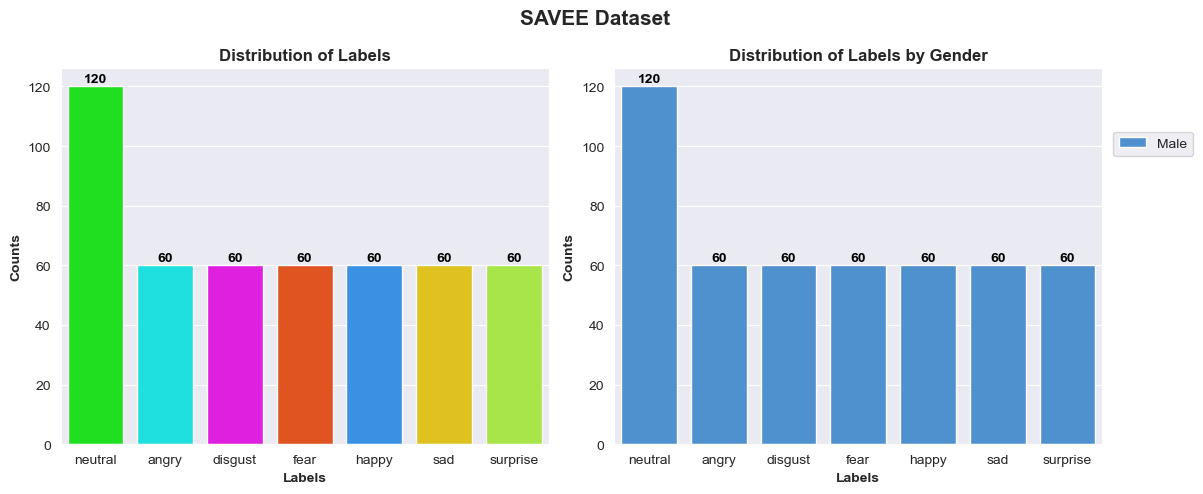

In [318]:
count_plot(SAVEE_df, 'Labels', 'SAVEE')

In [319]:
#Wave
def waveform(samples, sample_rate, file_name):
    plt.figure(figsize=(12,3))
    lb.display.waveshow(samples, sr = sample_rate)
    plt.title(f'Wave of {file_name}')
    plt.ylabel('Amplitude')
    plt.xlabel('Time(s)')
    plt.show()

#Spectrogram
def spectrogram(samples, sample_rate, file_name):
    plt.figure(figsize=(13,3))
    D = lb.amplitude_to_db(np.abs(lb.stft(samples)), ref=np.max)
    lb.display.specshow(D, sr=sample_rate, x_axis = 'time', y_axis = 'log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram of {file_name}')
    plt.ylabel('Frequency(Hz)')
    plt.xlabel('Time(s)')
    plt.show()

#Mel PowerSpectrogram
def mel_spectrogram(samples, sample_rate, file_name):
    plt.figure(figsize=(13,3))
    S = lb.feature.melspectrogram(y=samples, sr=sample_rate, n_mels= 128)
    S_DB = lb.amplitude_to_db(S, ref=np.max)
    lb.display.specshow(S_DB, sr=sample_rate, x_axis = 'time', y_axis = 'mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Power Spectrogram of {file_name}')
    plt.ylabel('Frequency(Hz)')
    plt.xlabel('Time(s)')
    plt.show()

#MFCC(Mel-Frequency Cepstral Coefficients)
def MFCC(samples, sample_rate, file_name):
    plt.figure(figsize=(13,5))
    mfccs = lb.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=13)
    lb.display.specshow(mfccs, sr=sample_rate, x_axis = 'time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Frequency Cepstral Coefficients(MFCC) of {file_name}')
    plt.ylabel('MFCC coeffs')
    plt.xlabel('Time(s)')
    plt.show()

def audio_plot(df, index):
    file_name = df.path[index]

    print(f'Audio file name : {file_name}')
    ipd.display(ipd.Audio(file_name))

    samples, sample_rate = lb.load(file_name)
    print(f'\nSample Rate     : {sample_rate} \nSamples         : {samples} \n')

    waveform(samples, sample_rate, file_name)

    spectrogram(samples, sample_rate, file_name)

    mel_spectrogram(samples, sample_rate, file_name)

    MFCC(samples, sample_rate, file_name)


Audio file name : ../data/SAVEE/ALL/DC_d11.wav



Sample Rate     : 22050 
Samples         : [0.02923239 0.04258326 0.03758717 ... 0.04064354 0.039179   0.04238518] 



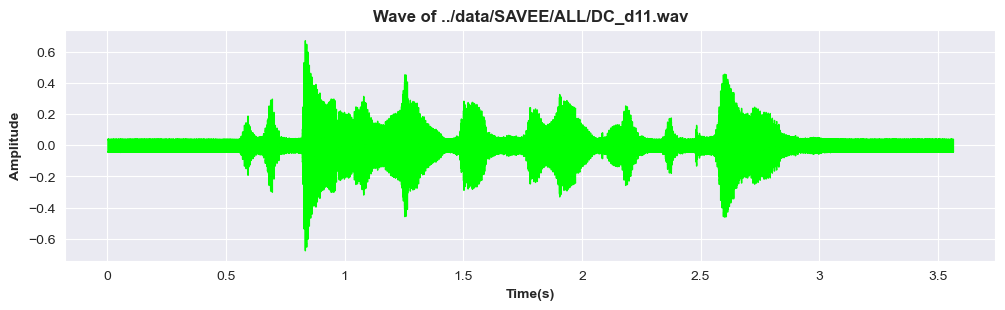

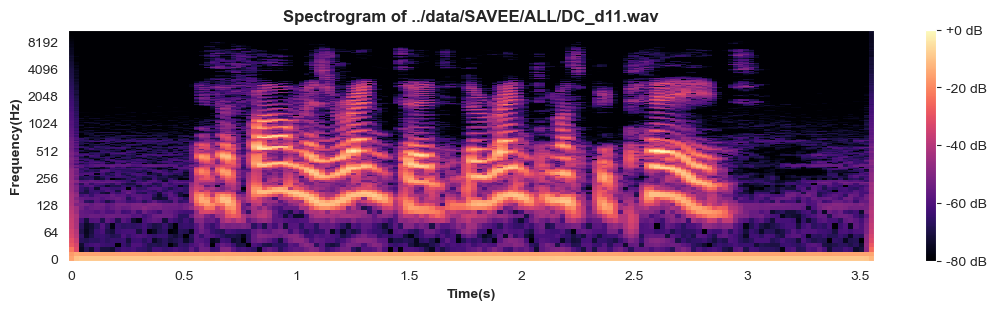

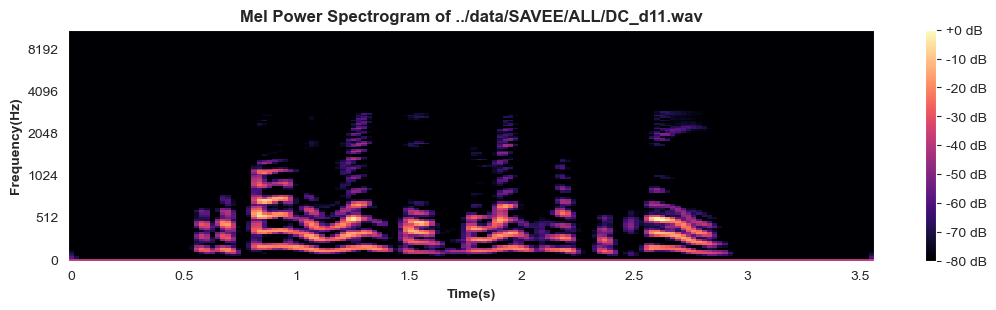

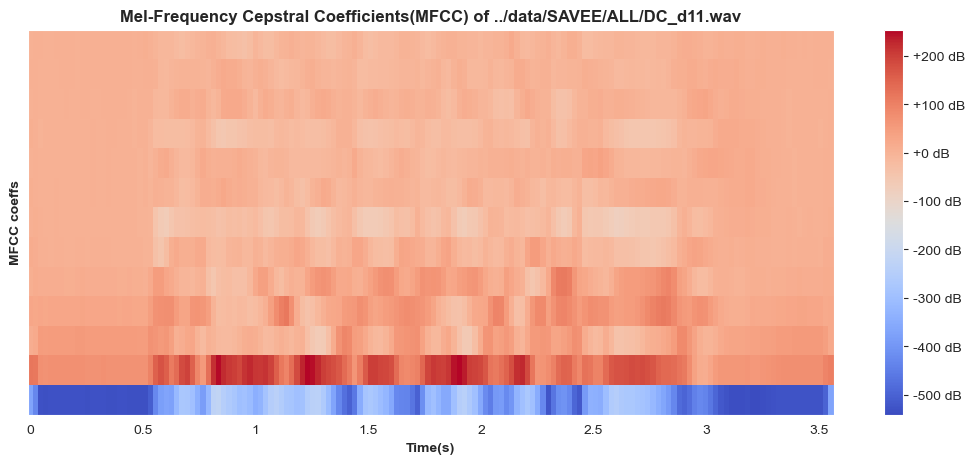

In [320]:
audio_plot(SAVEE_df, 25)

## 2. TESS dataset

- Only female speakers. (2 females - Young and Old)

<u>*Assumptions*</u>

1. Consider all feamles as a single group without differentiating between young and old females.
2. Specilized 'pleasant suprise' is considered a 'suprise'.

In [321]:
dir = os.listdir(tess_path)
dir

['OAF_angry',
 'OAF_disgust',
 'OAF_Fear',
 'OAF_happy',
 'OAF_neutral',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [322]:
emotion = []
path = []

patterns = {
    'angry': re.compile(r'(OAF|YAF)_angry', re.IGNORECASE),
    'disgust': re.compile(r'(OAF|YAF)_disgust', re.IGNORECASE),
    'fear': re.compile(r'(OAF|YAF)_fear', re.IGNORECASE),
    'happy': re.compile(r'(OAF|YAF)_happy', re.IGNORECASE),
    'neutral': re.compile(r'(OAF|YAF)_neutral', re.IGNORECASE),
    'surprise': re.compile(r'(OAF|YAF)_(pleasant_surprise|pleasant_surprised)', re.IGNORECASE),
    'sad': re.compile(r'(OAF|YAF)_sad', re.IGNORECASE)
}

for i in os.listdir(tess_path):
    fname = os.listdir(tess_path + i)

    for f in fname:
        matched = False

        for key, pattern in patterns.items():
            if pattern.match(i):
                emotion.append(key)
                matched = True
                break
            if not matched:
                emotion.append('error')

            path.append(os.path.join(tess_path, i, f))

TESS_df = pd.DataFrame({'Labels': emotion, 'Source': 'TESS', 'Gender':'Female'})
path_df = pd.DataFrame({'path': path})
TESS_df = pd.concat([TESS_df, path_df], axis=1)

In [323]:
TESS_df.shape

(11200, 4)

In [324]:
TESS_df.sample(5)

,Labels,Source,Gender,path
579,disgust,TESS,Female,../data/TESS Toronto emotional speech set data...
1187,fear,TESS,Female,../data/TESS Toronto emotional speech set data...
3402,error,TESS,Female,../data/TESS Toronto emotional speech set data...
5414,error,TESS,Female,../data/TESS Toronto emotional speech set data...
2092,error,TESS,Female,../data/TESS Toronto emotional speech set data...


In [325]:
TESS_df[TESS_df['Labels']=="error"]

,Labels,Source,Gender,path
200,error,TESS,Female,../data/TESS Toronto emotional speech set data...
202,error,TESS,Female,../data/TESS Toronto emotional speech set data...
204,error,TESS,Female,../data/TESS Toronto emotional speech set data...
206,error,TESS,Female,../data/TESS Toronto emotional speech set data...
208,error,TESS,Female,../data/TESS Toronto emotional speech set data...
...,...,...,...,...
11194,error,TESS,Female,NaN
11195,error,TESS,Female,NaN
11196,error,TESS,Female,NaN
11197,error,TESS,Female,NaN


In [326]:
TESS_df['Labels'].value_counts()

Labels
error       8400
angry        400
disgust      400
fear         400
happy        400
neutral      400
surprise     400
sad          400
Name: count, dtype: int64

In [327]:
TESS_df = TESS_df[TESS_df['Labels'] != "error"]

In [328]:
TESS_df.shape

(2800, 4)

In [329]:
TESS_df['Labels'].value_counts()

Labels
angry       400
disgust     400
fear        400
happy       400
neutral     400
surprise    400
sad         400
Name: count, dtype: int64

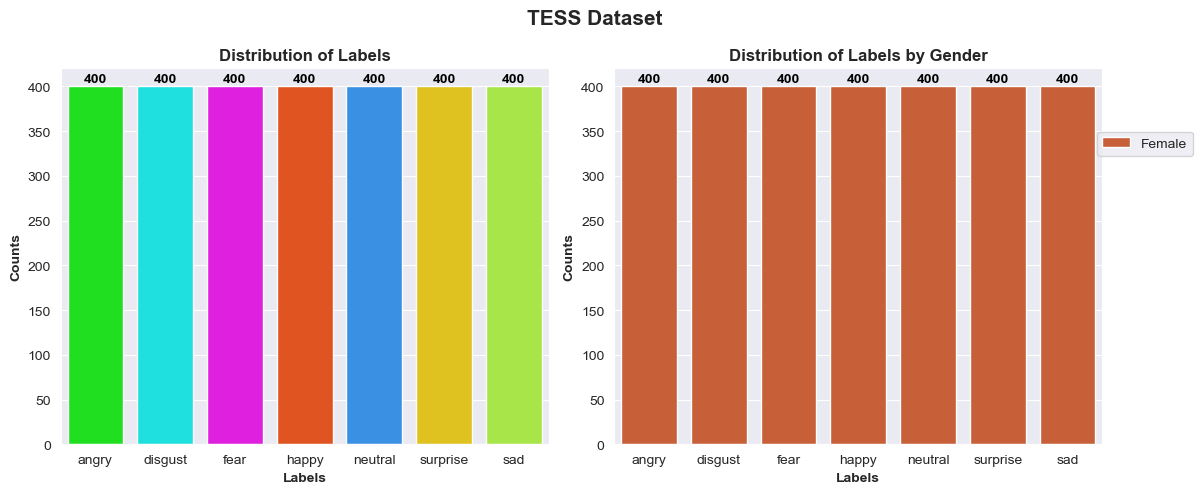

In [330]:
count_plot(TESS_df, 'Labels','TESS')

Audio file name : ../data/TESS Toronto emotional speech set data/OAF_disgust\OAF_dab_disgust.wav



Sample Rate     : 22050 
Samples         : [2.0802595e-06 1.0145905e-04 1.4958496e-04 ... 7.0398283e-04 6.0539861e-04
 3.0529770e-04] 



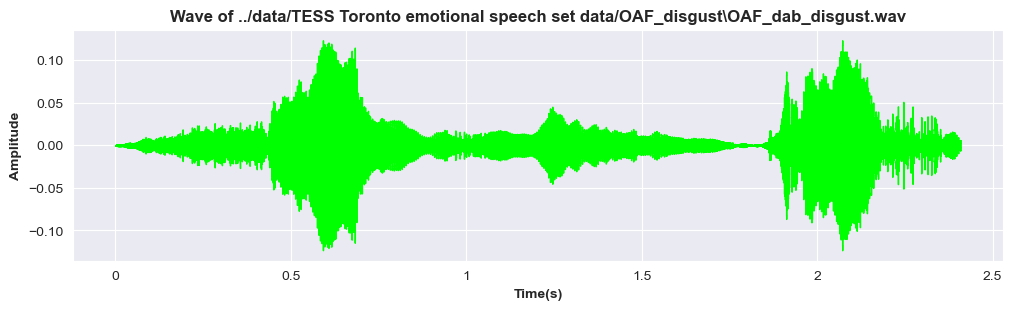

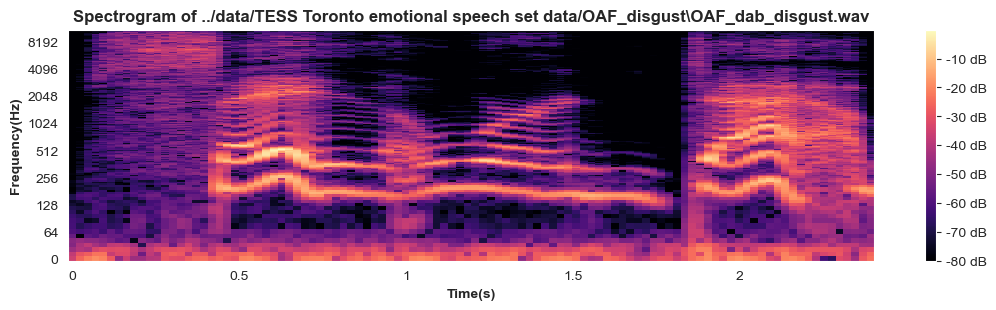

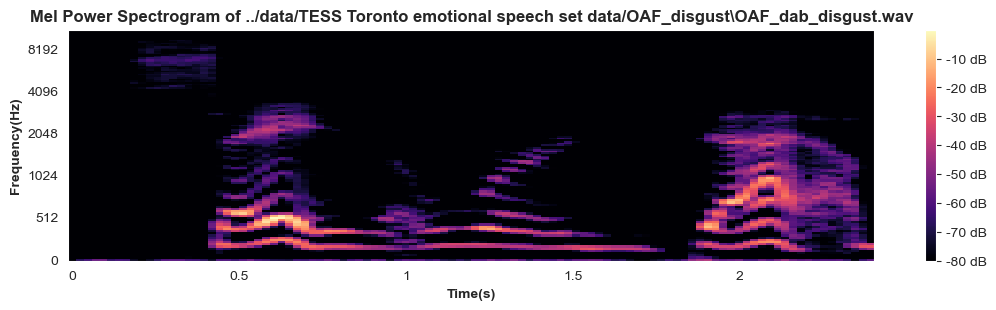

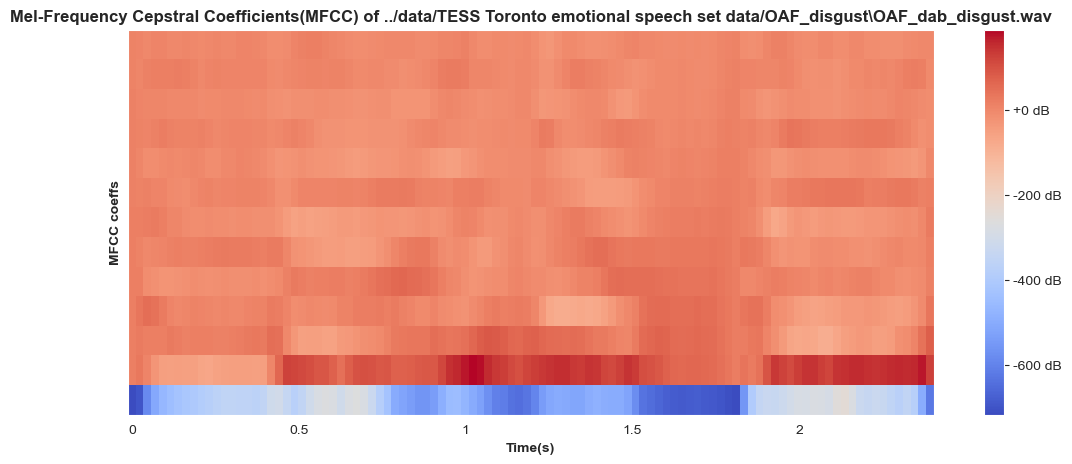

In [331]:
audio_plot(TESS_df, 25)

## 3. CREMA-D dataset

- Includes different speakers for different ethinicities.
- 'Suprise' emotion is missing.
- There are 91 actors.(48-Male, 43-Female)
- There 12 sentences.

    | Sentences                                | Acronym |
    |------------------------------------------|---------|
    | It's eleven o'clock                      | IEO     |
    | That is exactly what happened            | TIE     |
    | I'm on my way to the meeting             | IOM     |
    | I wonder what this is about              | IWW     |
    | The airplane is almost full              | TAI     |
    | Maybe tomorrow it will be cold           | MTI     |
    | I would like a new alarm clock           | IWL     |
    | I think I have a doctor's appointment    | ITH     |
    | Don't forget a jacket                    | DFA     |
    | I think I've seen this before            | ITS     |
    | The surface is slick                     | TSI     |
    | We'll stop in a couple of minutes        | WSI     |


-  There are 6 types of emotions (No suprise).

    | Emotion Code | Emotion  |
    |--------------|----------|
    | ANG          | angry    |
    | DIS          | disgust  |
    | FEA          | fear     |
    | HAP          | happy    |
    | NEU          | neutral  |
    | SAD          | sad      |

In [332]:
print(os.listdir(cremad_path)[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [333]:
path = []
actor_ids = []
emotion = []

mapping = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad',
    'SUR': 'surprise'
}

reg_pattern = re.compile(r'(\d{4})_.*?_(\w{3})_')

for fname in os.listdir(cremad_path):
    if fname.endswith('.wav'):
        match = reg_pattern.match(fname)
        if match:
            actor_id = match.group(1)
            emo_code = match.group(2)
            label = mapping.get(emo_code, 'error')
            actor_ids.append(actor_id)
            emotion.append(label)
            path.append(os.path.join(cremad_path, fname))

CREMAD_df = pd.DataFrame({'Labels': emotion, 'Source': 'CREMAD','actor_id':actor_ids})
path_df = pd.DataFrame({'path': path})
CREMAD_df = pd.concat([CREMAD_df, path_df], axis=1)

In [334]:
CREMAD_df.shape

(7442, 4)

In [335]:
CREMAD_df.sample(5)

,Labels,Source,actor_id,path
190,sad,CREMAD,1003,../data/CREMA-D/AudioWAV\1003_IOM_SAD_XX.wav
6798,fear,CREMAD,1084,../data/CREMA-D/AudioWAV\1084_IEO_FEA_HI.wav
1240,disgust,CREMAD,1016,../data/CREMA-D/AudioWAV\1016_IOM_DIS_XX.wav
1244,sad,CREMAD,1016,../data/CREMA-D/AudioWAV\1016_IOM_SAD_XX.wav
6822,fear,CREMAD,1084,../data/CREMA-D/AudioWAV\1084_ITS_FEA_XX.wav


In [336]:
CREMAD_df['Labels'].value_counts()

Labels
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64

In [337]:
#demographics 
crema_demo_df = pd.read_csv('../data/CREMA-D/VideoDemographics.csv')
print(crema_demo_df.shape)

(91, 5)


In [338]:
crema_demo_df.head()

,ActorID,Age,Sex,Race,Ethnicity
0,1001,51,Male,Caucasian,Not Hispanic
1,1002,21,Female,Caucasian,Not Hispanic
2,1003,21,Female,Caucasian,Not Hispanic
3,1004,42,Female,Caucasian,Not Hispanic
4,1005,29,Male,African American,Not Hispanic


In [339]:
crema_demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ActorID    91 non-null     int64 
 1   Age        91 non-null     int64 
 2   Sex        91 non-null     object
 3   Race       91 non-null     object
 4   Ethnicity  91 non-null     object
dtypes: int64(2), object(3)
memory usage: 3.7+ KB


In [340]:
CREMAD_df['actor_id'] = CREMAD_df['actor_id'].astype('int')

In [341]:
CREMAD_detailed_df = pd.merge(crema_demo_df, CREMAD_df, left_on='ActorID', right_on='actor_id', how='inner')

In [342]:
CREMAD_detailed_df.shape

(7442, 9)

In [343]:
CREMAD_detailed_df.sample(5)

,ActorID,Age,Sex,Race,Ethnicity,Labels,Source,actor_id,path
404,1005,29,Male,African American,Not Hispanic,disgust,CREMAD,1005,../data/CREMA-D/AudioWAV\1005_WSI_DIS_XX.wav
598,1008,46,Female,Caucasian,Not Hispanic,happy,CREMAD,1008,../data/CREMA-D/AudioWAV\1008_IOM_HAP_XX.wav
5035,1062,56,Male,Caucasian,Not Hispanic,angry,CREMAD,1062,../data/CREMA-D/AudioWAV\1062_MTI_ANG_XX.wav
6173,1076,25,Female,Caucasian,Not Hispanic,happy,CREMAD,1076,../data/CREMA-D/AudioWAV\1076_IWL_HAP_XX.wav
4540,1056,52,Female,African American,Not Hispanic,happy,CREMAD,1056,../data/CREMA-D/AudioWAV\1056_IWW_HAP_XX.wav


In [344]:
CREMAD_detailed_df = CREMAD_detailed_df.rename(columns={'Sex': 'Gender'})

In [345]:
CREMAD_detailed_df.groupby('Gender')['Labels'].value_counts()

Gender  Labels 
Female  angry      600
        disgust    600
        fear       600
        happy      600
        sad        600
        neutral    512
Male    angry      671
        disgust    671
        fear       671
        happy      671
        sad        671
        neutral    575
Name: count, dtype: int64

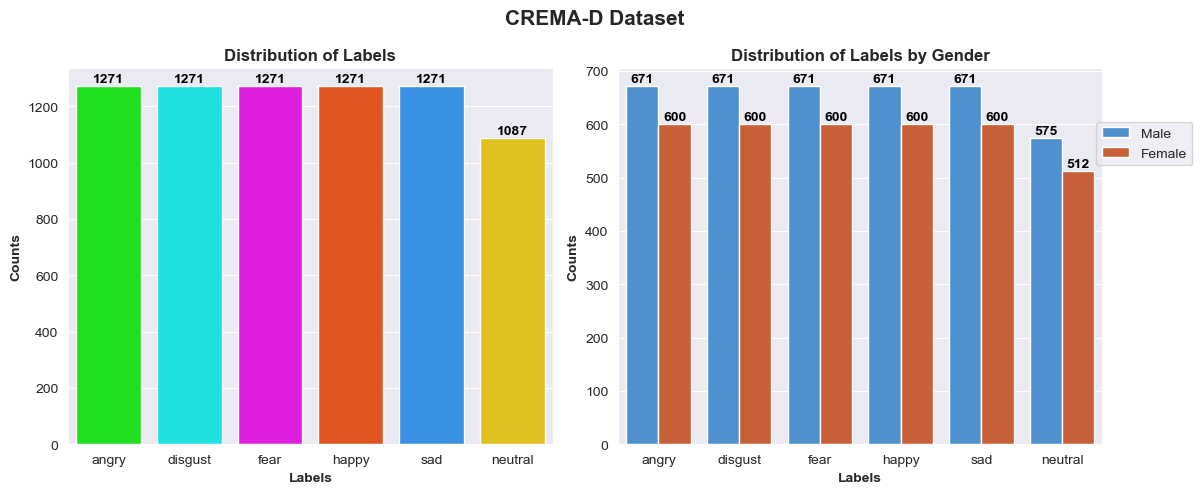

In [346]:
count_plot(CREMAD_detailed_df, 'Labels', 'CREMA-D')

Audio file name : ../data/CREMA-D/AudioWAV\1001_IOM_HAP_XX.wav



Sample Rate     : 22050 
Samples         : [ 1.2928119e-03  1.6535702e-03  1.6670754e-03 ...  7.7503351e-12
 -1.3347955e-11  0.0000000e+00] 



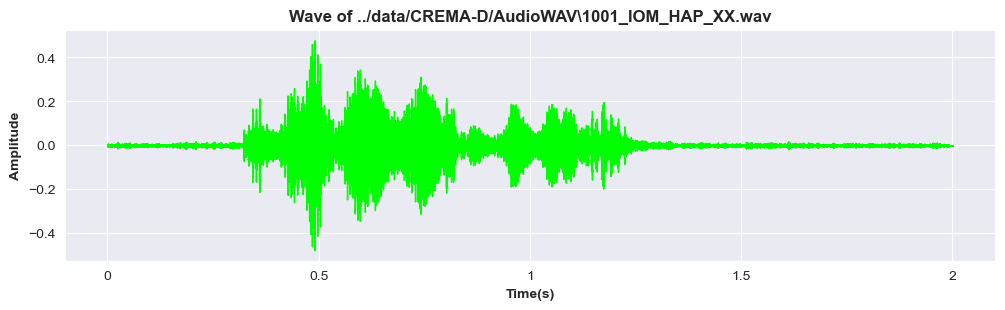

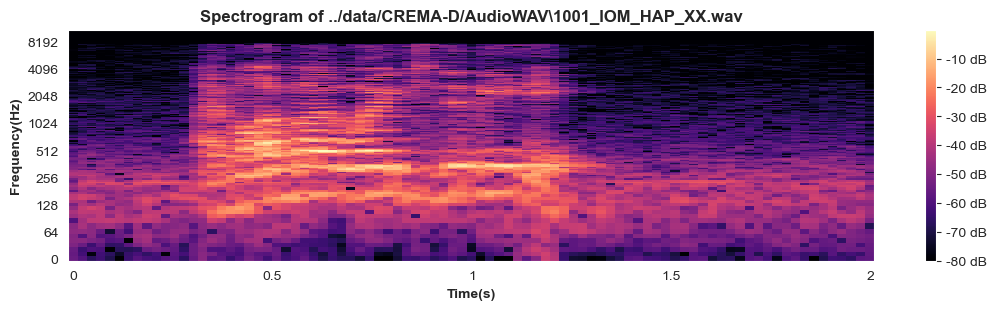

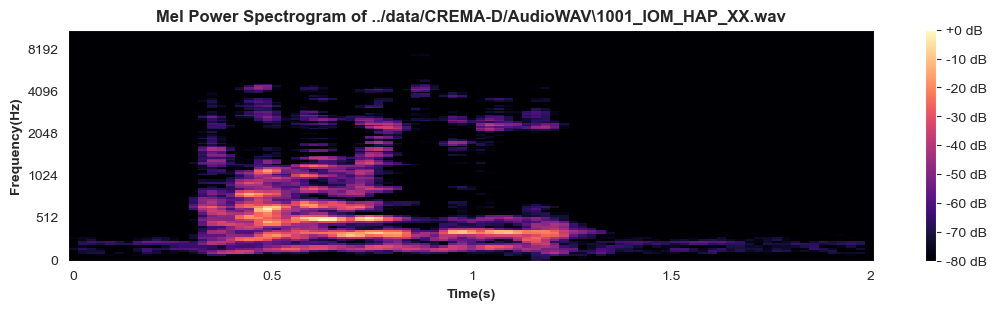

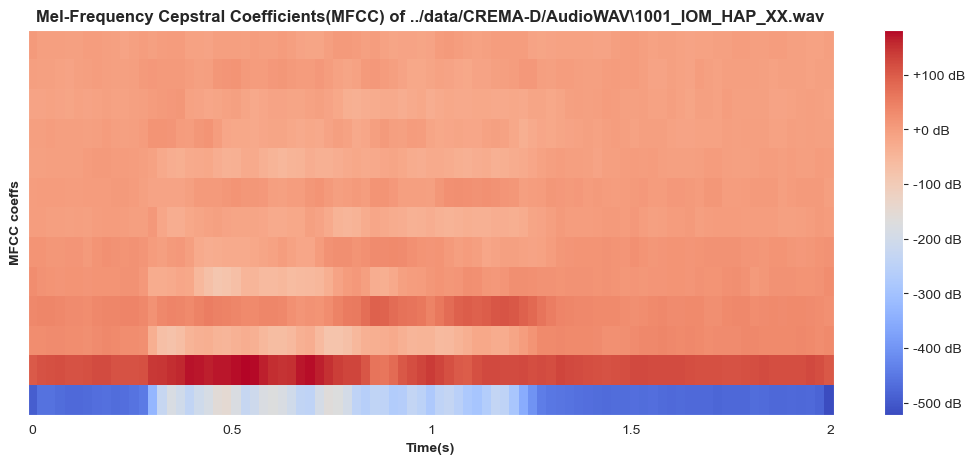

In [347]:
audio_plot(CREMAD_detailed_df, 25)

## 4. RAVDESS dataset

- includes both speeches and songs.

In [348]:
print(os.listdir(ravdess_path)[0:10])

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10']


In [349]:
emotion = []
gender = []
path = []

for i in os.listdir(ravdess_path):
    fname = os.listdir(ravdess_path + i)
    for f in fname:
        temp = f.split('.')[0].split('-')
        emotion.append(int(temp[2]))
        temp1 = int(temp[6])

        if temp1 %2 ==0:
            temp2 = 'Female'
        else:
            temp2 = 'Male'
        
        gender.append(temp2)
        path.append(ravdess_path + i + '/' +f)

RAVDESS_df = pd.DataFrame({'Labels':emotion, 'Gender': gender})

mapping = {1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
RAVDESS_df['Labels'] = RAVDESS_df['Labels'].map(mapping)
path_df = pd.DataFrame({'path': path})
RAVDESS_df = pd.concat([RAVDESS_df, path_df], axis=1)

In [350]:
RAVDESS_df.sample(5)

,Labels,Gender,path
567,sad,Female,../data/RAVDESS/audio_speech_actors_01-24/Acto...
481,neutral,Male,../data/RAVDESS/audio_speech_actors_01-24/Acto...
554,happy,Female,../data/RAVDESS/audio_speech_actors_01-24/Acto...
476,surprise,Female,../data/RAVDESS/audio_speech_actors_01-24/Acto...
811,angry,Female,../data/RAVDESS/audio_speech_actors_01-24/Acto...


In [351]:
RAVDESS_df['Labels'].value_counts()

Labels
neutral     288
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64

In [352]:
RAVDESS_df.groupby('Gender')['Labels'].value_counts()

Gender  Labels  
Female  neutral     144
        angry        96
        disgust      96
        fear         96
        happy        96
        sad          96
        surprise     96
Male    neutral     144
        angry        96
        disgust      96
        fear         96
        happy        96
        sad          96
        surprise     96
Name: count, dtype: int64

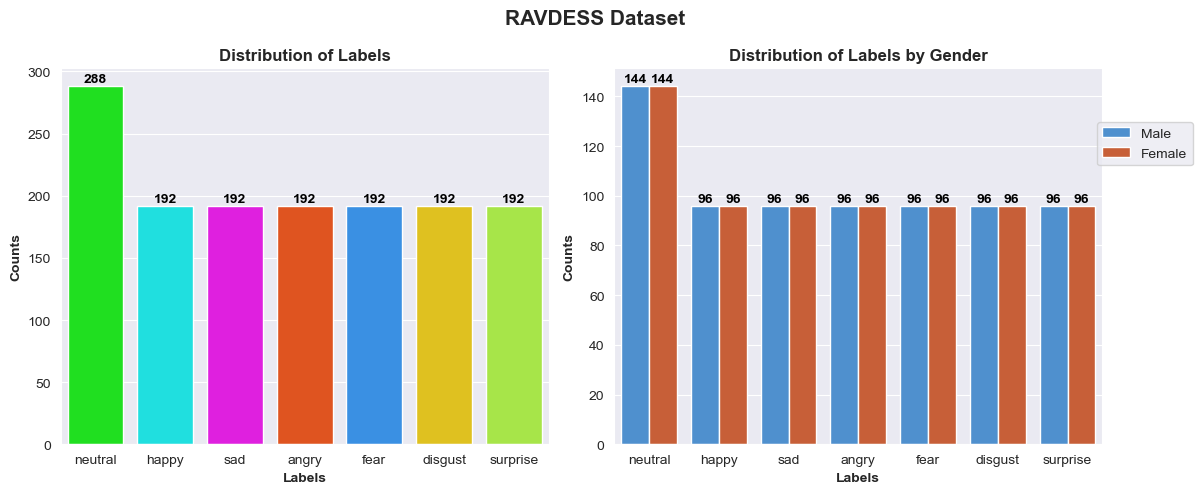

In [353]:
count_plot(RAVDESS_df, 'Labels', 'RAVDESS')

Audio file name : ../data/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-04-02-01-02-01.wav



Sample Rate     : 22050 
Samples         : [ 4.3061231e-14  1.9672266e-13  7.2149528e-14 ... -2.3806250e-13
 -2.2418325e-13  2.0970706e-14] 



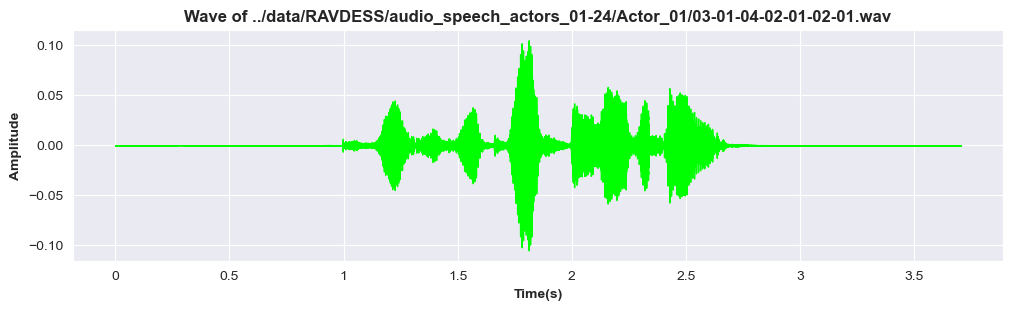

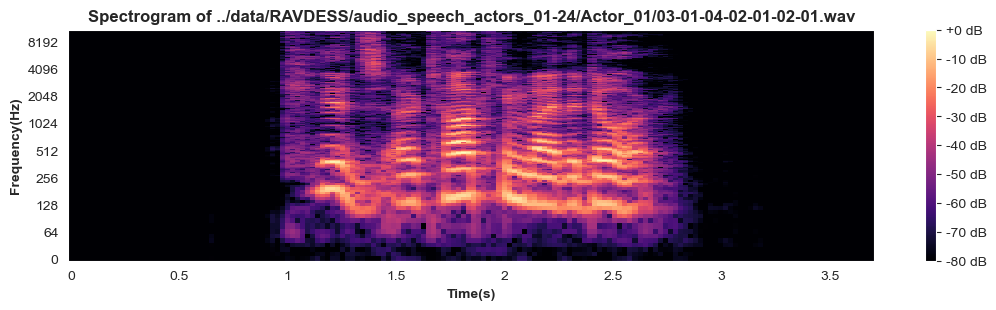

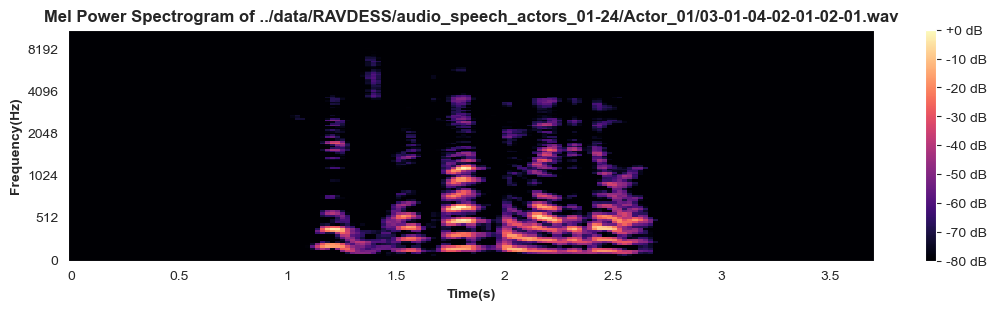

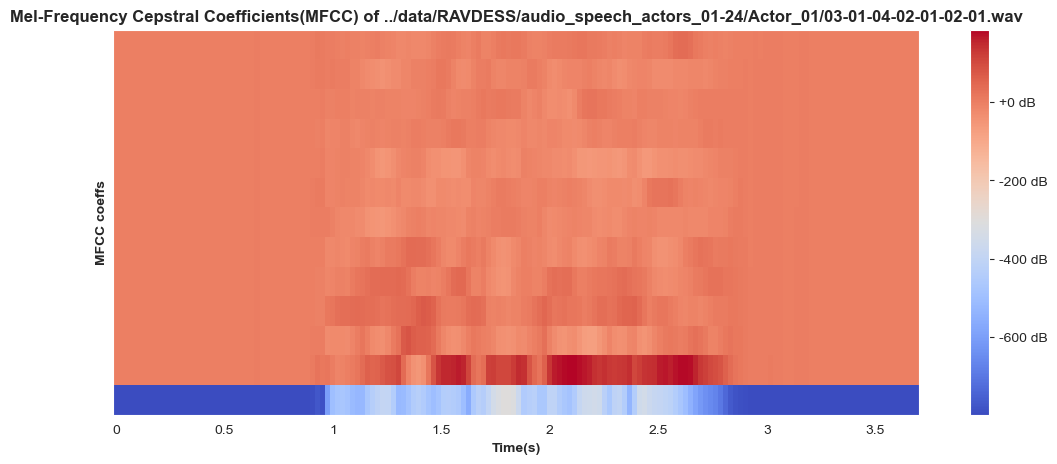

In [354]:
audio_plot(RAVDESS_df, 25)